In [3]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

from src.embedding import Embedding
from src.environment import Rewards_env
from src.evaluations import evaluate, plot_eva
from src.regression import *
from src.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/ownCloud/git/Solaris/synbio_rbs/demo
['/home/admin-u6015325/ownCloud/git/Solaris/synbio_rbs/demo', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.6.999662501/pythonFiles/vscode_datascience_helpers', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.6.999662501/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.6.999662501/pythonFiles/lib/python', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/Solaris/synbio_rbs']


# Plot setting

In [4]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rcParams['axes.labelsize'] = MEDIUM_SIZE # 15
rcParams['xtick.labelsize'] = SMALL_SIZE # 13
rcParams['ytick.labelsize'] = SMALL_SIZE # 13
rcParams['legend.fontsize'] = SMALL_SIZE # 13
rcParams['axes.titlesize'] = BIGGER_SIZE  # 15
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Computer Modern Roman']
# rcParams['text.usetex'] = True

# set color
# https://www.thinkingondata.com/something-about-viridis-library/
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
color_dict = {}

viridis = cm.get_cmap('viridis', 20)
tab10 = cm.get_cmap('tab20', 20)

color_dict['Consensus'] = tab10.colors[0]
color_dict['Reference'] = tab10.colors[6]
color_dict['BPS-C'] = tab10.colors[14]
color_dict['BPS-NC'] = tab10.colors[12]
color_dict['UNI'] = tab10.colors[10]
color_dict['PPM'] = tab10.colors[11]

# color_dict['Bandit-0'] = viridis.colors[0]
# color_dict['Bandit-1'] = viridis.colors[1]
# color_dict['Bandit-2'] = viridis.colors[2]
# color_dict['Bandit-3'] = viridis.colors[3]

color_dict['Bandit-0'] = viridis.colors[3]
color_dict['Bandit-1'] = viridis.colors[8]
color_dict['Bandit-2'] = viridis.colors[13]
color_dict['Bandit-3'] = viridis.colors[18]

color_dict['Unlabeled'] = tab10.colors[15]
color_dict['Random'] = tab10.colors[10]

bandit_color_dict = {}

bandit_color_dict['Bandit-0'] = viridis.colors[3]
bandit_color_dict['Bandit-1'] = viridis.colors[8]
bandit_color_dict['Bandit-2'] = viridis.colors[13]
bandit_color_dict['Bandit-3'] = viridis.colors[18]

# generate valids names and path for plots

def valid_name(name):
    return name.replace('_', ' ')  
def valid_path(path):
    return path.replace(' ', '_')

folder_path = '../data/'
# plot_path = '../../notebooks/paper_plots/'
plot_path = '../../paper/plots/Main_Paper/'
plot_path_supp = '../../paper/plots/Supplementary/'

# plot_path = '../../../paper/writing/wcb_icml2021/wcb2021_plot/'

In [5]:
plot_swarm_flag = True
plot_quant_flag = True
plot_scatter_flag = True
plot_tsne_flag = True
plot_hist_flag = True
gene_rec_flag = False

In [6]:
wcb_color_dict = {}

viridis = cm.get_cmap('viridis', 20)
tab10 = cm.get_cmap('tab20', 20)

wcb_color_dict['Consensus'] = tab10.colors[0]
wcb_color_dict['Reference'] = tab10.colors[6]
wcb_color_dict['Random'] = tab10.colors[10]

# color_dict['Bandit-0'] = viridis.colors[0]
# color_dict['Bandit-1'] = viridis.colors[1]
# color_dict['Bandit-2'] = viridis.colors[2]
# color_dict['Bandit-3'] = viridis.colors[3]

wcb_color_dict['Bandit-0'] = viridis.colors[3]
wcb_color_dict['Bandit-1'] = viridis.colors[8]
wcb_color_dict['Bandit-2'] = viridis.colors[13]
wcb_color_dict['Bandit-3'] = viridis.colors[18]
wcb_color_dict['Unlabeled'] = tab10.colors[15]


# Read data

Define the following steps on each replicate:  
- A. In each round, substract the mean of every data points by the reference AVERAGE, and then add 100 (to make the values positive).  
- B. Take log (base e) transformation for each data points.  
- C. Apply z-score normalisation.  
    - C.1 on each round, so that the mean and variance of each replicate of data in each round is zero and one after normalisation. 
    - C.2 on all data, so that the mean and variance of each replicate of all data is zero and one after normalisation. 
- D. Apply min-max normalisation.
    - D.1 on each round
    - D.2 on all data
- E. Apply ratio normalisation. In each round, each data points is devided by the mean of refernce AVERAGE, so that in each round, the reference labels are almost 1. 
    - E.1 on each round
    - E.2 on all data

In [7]:
# read data

df_n = pd.read_csv(folder_path + 'Results_n.csv') # raw data
df_e1 = pd.read_csv(folder_path + 'Results_e1.csv')
df_abc2 = pd.read_csv(folder_path + 'Results_abc2.csv')
df_abc1 = pd.read_csv(folder_path + 'Results_abc1.csv')
df_bc1 = pd.read_csv(folder_path + 'Results_bc1.csv')
df_TOP30 = pd.read_excel(folder_path + "Plots.xlsx", sheet_name = "TOP30")
df_ALL = pd.read_excel(folder_path + "Plots.xlsx", sheet_name = "All")
df_Pos = pd.read_csv(folder_path + 'Pos_Change.csv') 
df_SD = pd.read_excel(folder_path + "Plots.xlsx", sheet_name = "SD")

In [8]:
df_e1['Group2'] = df_e1['Group']
df_e1.loc[df_e1['Group2'] == 'UNI', 'Group2'] = 'Random'
df_e1.loc[df_e1['Group2'] == 'PPM', 'Group2'] = 'Random'

# G-rich exploitation

In [7]:
Grich_dict = {}
for group in ['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2','Bandit-3']:
    Grich_dict[group] = 0
    seqs = np.asarray(df_e1.loc[df_e1['Group2'] == group, 'RBS6'].values)
#     print(seqs)
    for rbs6 in seqs:
        if rbs6.count('G') >= 3:
            Grich_dict[group] += 1
    Grich_dict[group] /= float(len(seqs))
Grich_dict

{'Random': 0.24561403508771928,
 'Bandit-0': 0.288135593220339,
 'Bandit-1': 0.3522727272727273,
 'Bandit-2': 0.45555555555555555,
 'Bandit-3': 0.5444444444444444}

# Swarmplot

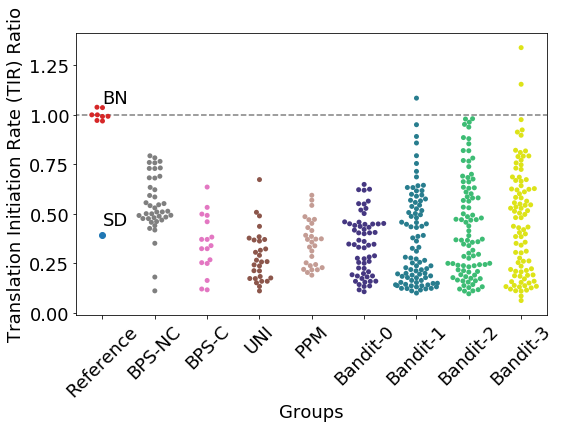

In [32]:
sns.set_palette(list(color_dict.values())[1:])
# sns.set_palette(list(wcb_color_dict.values())[1:])

if plot_swarm_flag:
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_e1, ax = axes, order=['Reference', 'BPS-NC', 'BPS-C', 'UNI', 'PPM', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])
#     sns.swarmplot(x = 'Group2', y = 'AVERAGE', data = df_e1, ax = axes, order=['Reference', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])
    y = df_e1[df_e1['Group'] == 'Consensus']['AVERAGE']
    axes.scatter(x = 0, y = y, color = color_dict['Consensus'])
    axes.plot([-1,9], [1,1], '--', color = 'grey')
    axes.text(0, 1.06, 'BN')
    axes.text(0, y + 0.05, 'SD')
    axes.set(xlabel='Groups', ylabel='Translation Initiation Rate (TIR) Ratio')
#     \n averaged over 6 technical replicates
#     axes.set_title('Swarmplot with TIR Labels (ratio)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(plot_path + 'swarmplot.pdf')

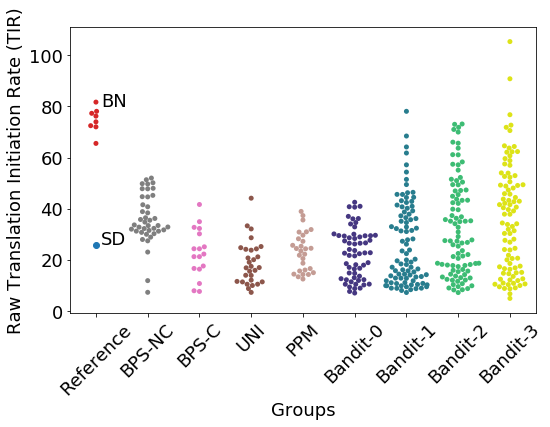

In [31]:
sns.set_palette(list(color_dict.values())[1:])

if plot_swarm_flag:
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_n, ax = axes, order=['Reference', 'BPS-NC', 'BPS-C', 'UNI', 'PPM', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])
#     sns.swarmplot(x = 'Group2', y = 'AVERAGE', data = df_e1, ax = axes, order=['Reference', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])
    y = df_n[df_n['Group'] == 'Consensus']['AVERAGE']
    axes.scatter(x = 0, y = y, color = color_dict['Consensus'])
#     axes.plot([-1,9], [1,1], '--', color = 'grey')
    axes.text(0.1, 80.06, 'BN')
    axes.text(0.1, y + 0.05, 'SD')
    axes.set(xlabel='Groups', ylabel='Raw Translation Initiation Rate (TIR)')
#     \n averaged over 6 technical replicates
#     axes.set_title('Swarmplot with TIR Labels (ratio)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(plot_path_supp + 'swarmplot_raw.pdf')

# Quantile plot

In [56]:

def quant_line(df, col = 'Group', title = 'Quantile of groups'):
    f, axes = plt.subplots(1, 1, figsize=(5, 6), sharex=False)
    quantile_levels = [0.9, 0.8, 0.7, 0.6, 0.5]
    used_groups = ['BPS-C', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']
    df_bandits = df.loc[df[col].isin(used_groups)]

    quant_dict = defaultdict(list)
    groups = df_bandits.groupby(col)
    

    for used_group in used_groups:
        quant_dict['max'].append(groups.get_group(used_group)['AVERAGE'].max())
    axes.plot(range(len(used_groups)), quant_dict['max'], marker = '.', linestyle = 'dashdot', markersize = 12, label = 'max', alpha = 0.8, color = 'orange')

    for quant in quantile_levels:
        for used_group in used_groups:
            quant_dict[quant].append(groups.get_group(used_group)['AVERAGE'].quantile(quant))
        axes.plot(range(len(used_groups)), quant_dict[quant], marker = '.', linestyle = 'dashdot', markersize = 12, label = str(quant) + ' Q', alpha = 0.8)
    print(quant_dict)
    # plt.plot(df_bandits.sort_values('AVERAGE',ascending=False).groupby(col).nth(4)['AVERAGE'], marker = '.', label = 'Top-5', alpha = 0.6)
    plt.legend(loc ='upper left', fontsize = 14) # , fontsize = 'small'
    axes.plot([0,5], [1,1], '--', color = 'grey')
    axes.set(xlabel='Groups', ylabel='Translation Initiation Rate (TIR) Ratio')
    plt.xticks(range(len(used_groups)), used_groups, rotation=45)
#     plt.title(title)
    plt.tight_layout()
    plt.savefig(plot_path + 'quantplot.pdf')

defaultdict(<class 'list'>, {'max': [0.6355002353408578, 0.6731121905694991, 0.6488630508039336, 1.0843835326002715, 0.9805295927639072, 1.3393002237887417], 0.9: [0.5126175895951041, 0.48747346713172657, 0.5502910767865824, 0.6429248180988563, 0.8188881842655179, 0.7943302808474251], 0.8: [0.48606102709042337, 0.42790759717818516, 0.45436991912116087, 0.5726443957870256, 0.6652405796511257, 0.6855804660165407], 0.7: [0.39841089374200994, 0.37490591882704616, 0.43987546313296955, 0.5012380384610717, 0.5803832982245711, 0.614240191230692], 0.6: [0.37127874065764077, 0.3607584906537748, 0.4043271769811853, 0.4353016573889231, 0.4754247532349284, 0.5384713337151814], 0.5: [0.3397304868278847, 0.3126751547111433, 0.3466603476183973, 0.2964867917414588, 0.3708493378384332, 0.45928848912100106]})


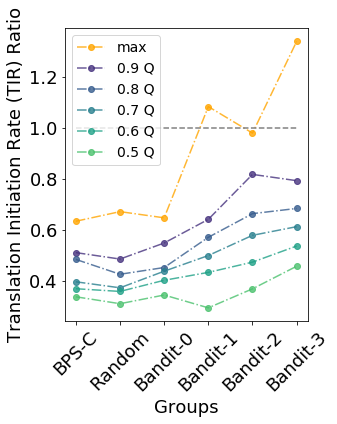

In [57]:
if plot_quant_flag:
    sns.set_palette('viridis') 
    quant_line(df_e1, 'Group2')
    

# TSNE plot

In [41]:
n_dim = 2

wds_kernel = WD_Shift_Kernel(l = 6, s=1)
distance = wds_kernel.distance(wds_kernel.kernel_all_normalised)

No saved kernel matrix. Calculate and save kernel matrix...
centering_flag:  True
unit_norm_flag:  True
Kernel saved.


In [42]:
distance.shape

(4138, 4138)

In [43]:

# dim reduction
tsne = TSNE(n_components = n_dim, metric = 'precomputed', random_state = 5)
tsne_distance = tsne.fit_transform(distance)

In [44]:
with open('../../data/idx_seq.pickle', 'rb') as handle:
    idx_seq_dict = pickle.load(handle)['idx_seq_dict']

group_dict = defaultdict(list)
group_TIR_dict = defaultdict(list)
group_RBS6_dict = defaultdict(list)
known_seq = set(df_e1['RBS'])
size = 120

for idx in range(distance.shape[0]):
    seq = idx_seq_dict[idx]
    if seq in known_seq:
        group = df_e1.loc[df_e1['RBS'] == seq, 'Group2'].values[0]
        TIR = df_e1.loc[df_e1['RBS'] == seq, 'AVERAGE'].values[0]
        RBS6 = df_e1.loc[df_e1['RBS'] == seq, 'RBS6'].values[0]
        # print(group)
        group_dict[group].append(idx)
        group_TIR_dict[group].append(TIR * size)
        group_RBS6_dict[group].append(RBS6)
        # idx_color_dict[idx] = color_dict[str(group)]
        # color_list.append(color_dict[str(group)])
    else:
        group_dict['Unlabeled'].append(idx)
        group_TIR_dict['Unlabeled'].append(0.2 * size)
        group_RBS6_dict['Unlabeled'].append(idx_seq_dict[idx])


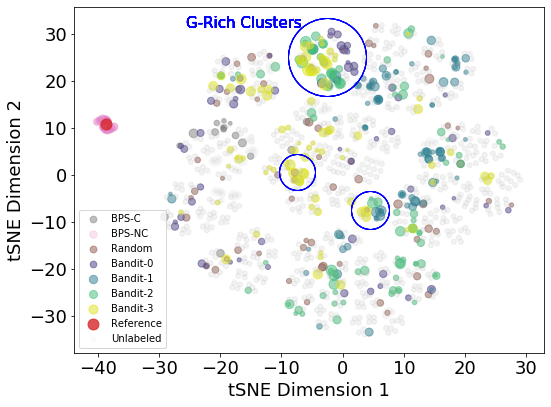

In [55]:
sns.set_palette(list(color_dict.values())[1:])

if plot_tsne_flag:
    rcParams['legend.fontsize'] = 10
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    groups = ['BPS-C', 'BPS-NC', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3', 'Reference', 'Unlabeled']
#     groups = ['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3', 'Reference', 'Unlabeled']
    for group in groups:
        idxes = np.asarray(group_dict[group])
        if group == 'Unlabeled':
            alpha = 0.05
        elif group == 'BPS-NC':
            alpha = 0.2
        elif group == 'Reference':
            alpha = 0.8
        else:
            alpha = 0.5
      
        plt.scatter(tsne_distance[idxes,0], tsne_distance[idxes,1], alpha = alpha, color = color_dict[group],  s = group_TIR_dict[group][:], label = group)
#         edgecolors = 'none',
        
        plt.plot(-2.5, 25, 'o',
                ms=39 * 2, mec='b', alpha = 0.6, mfc='none', mew=1)
        plt.plot(-7.5,0.5, 'o',
                ms=18 * 2, mec='b', alpha = 0.6, mfc='none', mew=1)
        plt.plot(4.5,-7.5, 'o',
                ms=19 * 2, mec='b', alpha = 0.6, mfc='none', mew=1)
        plt.annotate('G-Rich Clusters', xy=[-6, 25], xytext=(-120, 30),
                    textcoords='offset points',
                    color='b', size='small',
#                     arrowprops=dict(
#                         arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
#                         facecolor='b', shrinkB=39 * 1.2, alpha = 0.6)
                    )
        plt.legend(loc = 'lower left')
        plt.xlabel('tSNE Dimension 1')
        plt.ylabel('tSNE Dimension 2')
#         plt.title('TSNE for RBS design space')
        plt.tight_layout()
        plt.savefig(plot_path +'tsneplot.pdf')
        
rcParams['legend.fontsize'] = 13

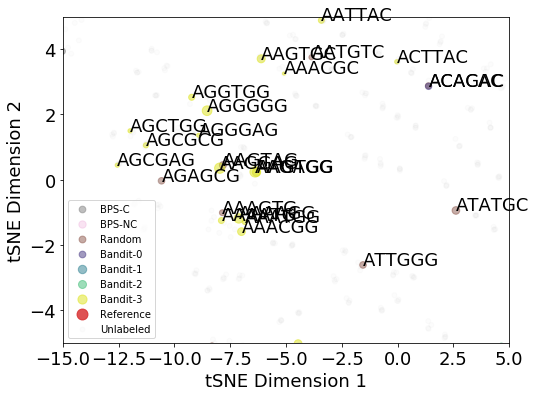

In [46]:
# from adjustText import adjust_text

# x_range = [0,10]
# y_range = [-10,0]

x_range = [-15,5]
y_range = [-5,5]

# x_range = [-10,0]
# y_range = [15,35]


if plot_tsne_flag:
    rcParams['legend.fontsize'] = 10
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    groups = ['BPS-C', 'BPS-NC', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3', 'Reference', 'Unlabeled']
#     groups = ['Bandit-3']
    for group in groups:
        idxes = np.asarray(group_dict[group])
        if group == 'Unlabeled':
            alpha = 0.05
        elif group == 'BPS-NC':
            alpha = 0.2
        elif group == 'Reference':
            alpha = 0.8
        else:
            alpha = 0.5
      
        plt.scatter(tsne_distance[idxes,0], tsne_distance[idxes,1], alpha = alpha, color = color_dict[group],  s = group_TIR_dict[group][:], label = group)
#         edgecolors = 'none',

        texts = []
        
        for i, idx in enumerate(idxes):
#             if tsne_distance[idx,0] >= -15 and tsne_distance[idx,0] <= 5 and tsne_distance[idx,1] >= -10 and tsne_distance[idx,1] <= 10 and group != 'Unlabeled':
            if tsne_distance[idx,0] >= x_range[0] and tsne_distance[idx,0] <= x_range[1] and tsne_distance[idx,1] >= y_range[0] and tsne_distance[idx,1] <= y_range[1] and group != 'Unlabeled':
                texts.append(plt.text(tsne_distance[idx,0], tsne_distance[idx,1], group_RBS6_dict[group][i]))
#         adjust_text(texts, x = tsne_distance[idxes,0], y = tsne_distance[idxes,1],  
#                     autoalign='y', force_points=0.1,
#                     only_move={'points':'y', 'text':'y'},
# #                     arrowprops=dict(arrowstyle="->", color='r')
#                    )
        
        plt.legend(loc = 'lower left')
        plt.xlabel('tSNE Dimension 1')
        plt.ylabel('tSNE Dimension 2')
        plt.xlim(x_range[0], x_range[1])
        plt.ylim(y_range[0], y_range[1])

#         plt.xlim(-15,5)
#         plt.ylim(-10,10)

#         plt.title('TSNE for RBS design space')
#         plt.tight_layout()
#         plt.savefig(plot_path +'tsneplot_zoomin.pdf')
        
rcParams['legend.fontsize'] = 13

# Histogram

In [47]:
def hist(df, title = 'Hist'):
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    df = df.append({'Group': 'Bandit-2', 'AVERAGE' : -0.1}, ignore_index=True) # for kde range
    df_bandits = df.loc[df['Group'].isin(['Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])]
    sns.histplot(data = df_bandits, x = 'AVERAGE', binwidth = 0.1, binrange = [0, 1.4], hue = 'Group', kde=True, 
                 kde_kws ={'clip': [0,1.4]}, alpha = 0.5)
    # df_random = df[df['Group2'] == 'Random']
    # sns.histplot(data = df_random, x = 'AVERAGE', hue = 'Group2', kde=True, color = color_dict['Random'])
    axes.set(xlabel='Translation Initiation Rate (TIR) Ratio')
#     plt.title(title)
    plt.xlim(0,1.4)
    plt.tight_layout()
    plt.savefig(plot_path +'histogram.pdf')
    print('mean:')
    print(df_bandits.groupby('Group').mean())
    print('0.9 quantile')
    print(df_bandits.groupby('Group').quantile(0.9))

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


mean:
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0    0.0  0.414860  0.298275  0.553395  0.282843  0.284523  0.237629   
Bandit-1    1.0  0.352341  0.283970  0.263911  0.435496  0.466647  0.427217   
Bandit-2    2.0  0.463039  0.451691  0.433064  0.479915  0.414802  0.378265   
Bandit-3    3.0  0.508092  0.448569  0.445741  0.437378  0.449300  0.483641   

           AVERAGE       STD  
Group                         
Bandit-0  0.345254  0.131296  
Bandit-1  0.371597  0.112093  
Bandit-2  0.430897  0.093794  
Bandit-3  0.462120  0.066663  
0.9 quantile
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0    0.0  0.642278  0.454360  0.851110  0.454439  0.444172  0.384917   
Bandit-1    1.0  0.626264  0.473488  0.416890  0.822521  0.853072  0.754949   
Band

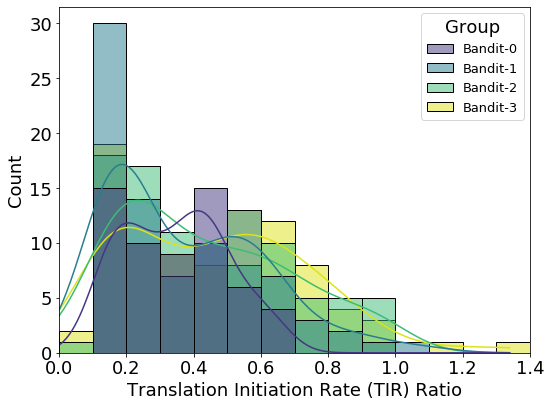

In [48]:
if plot_hist_flag:
#     sns.set_palette('viridis') 
    sns.set_palette(list(bandit_color_dict.values())) 
    hist(df_e1, 'Histogram')

# Scatterplot

In [9]:
# copy from the pipeline for recommending round 2 seq
from src.batch_ucb import *
from src.regression import *
from scipy.stats import spearmanr

rec_size = 90
l = 6
s = 1
beta = 0
alpha = 2
sigma_0 = 1
kernel = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True

sns.set_palette('tab10') 

In [10]:
def run_regression(df,kernel, embedding, predictor = GPR_Predictor, train_idx = None, test_idx = None, 
                    eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, sigma_0=1, alpha = 2, 
                    eva_on='seqs', title = 'Prediction',
                    kernel_norm_flag = True, centering_flag = False, unit_norm_flag = True, kernel_over_all_flag = True):
    title = title + ' centering' + str(centering_flag) + 'unitnorm' + str(unit_norm_flag)
    # train and test on round 0
    gpr_train_samples = predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel,
                kernel_norm_flag = kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag,
                embedding = embedding, eva_metric = eva_metric, l = l, s = s, sigma_0 = sigma_0, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression(random_state = 0)

    return gpr_train_samples
    # gpr_train_samples.scatter_plot(title = title)

In [11]:
def scatter_plot(predictor_list, title, plot_title = 'Prediction'):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        # fig, axes = plt.subplots(1,4, figsize = (20,6))
        fig, axes = plt.subplots(2,2, figsize = (12,12))
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            if i < 2:
                row = 0
            else:
                row = 1

            axes[row, i % 2].scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes[row, i % 2].scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes[row, i % 2].set_xlabel('True TIR')
            axes[row, i % 2].set_ylabel('Predict TIR')
            axes[row, i % 2].legend()
            axes[row, i % 2].plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes[row, i % 2].set_title('\n' + title[i] + 
                '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

#         fig.suptitle(plot_title, size = 16, y = 0.98)
        fig.tight_layout()
#         fig.subplots_adjust(top=0.85)
        fig.savefig(plot_path + 'scatter_' + valid_path(plot_title) + '.pdf')

In [12]:
def scatter_plot_single(predictor_list, title, plot_title = 'Prediction', save_to = ''):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        # fig, axes = plt.subplots(1,4, figsize = (20,6))
        sns.set_palette('tab10') 
        
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            fig, axes = plt.subplots(1,1, figsize = (6,6))

            axes.scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes.scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes.set_xlabel('True TIR')
            axes.set_ylabel('Predict TIR')
            axes.legend()
            axes.plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes.set_title('\n' + title[i] + 
                '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

#           fig.suptitle(plot_title, size = 16, y = 0.98)
            fig.tight_layout()
    #       fig.subplots_adjust(top=0.85)
            fig.savefig(save_to + 'scatter_' + valid_path(plot_title) + '_' + str(i) + '.pdf')

In [13]:
def generate_predictors(df, kernel, embedding, kernel_norm_flag = True, centering_flag = True, unit_norm_flag = True, kernel_over_all_flag = True):
    predictors = []
    for i in range(1,4):
        title = 'Train < ' + str(i)+ ' and Test ' + str(i)
        predictor = run_regression(df, kernel, embedding, train_idx = df['Round'] < i, test_idx = df['Round'] == i, title = title, centering_flag=centering_flag, unit_norm_flag=unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag)
        predictors.append(predictor)

    predictor = run_regression(df, kernel, embedding, title = 'Train and Test on All Rounds', centering_flag=centering_flag, unit_norm_flag=unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag)
    predictors.append(predictor)
    return predictors
    

In [14]:
if plot_scatter_flag:
    centering_flag = True
    unit_norm_flag = True
    df_abc1_TT_predictors = generate_predictors(df_abc1, kernel, embedding, kernel_norm_flag = True, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag)

X train shape:  (1055, 20)
X test shape:  (89, 20)
create kernel instance
No saved kernel matrix. Calculate and save kernel matrix...
centering_flag:  True
unit_norm_flag:  True
Kernel saved.
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
gp_reg pred
finish reg
X train shape:  (1589, 20)
X test shape:  (93, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
gp_reg pred
finish reg
X train shape:  (2147, 20)
X test shape:  (93, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_

#################################
  Evaluation   Train Round 0; Test Round 1
#################################
<function mean_squared_error at 0x7f4019d5d6a8>
Train:  0.18183812490892862
Test:  1.65636596553315
<function r2_score at 0x7f4019d5d8c8>
Train:  0.7898224403285338
Test:  -0.8391571851389397
spearman cor:
Train:  SpearmanrResult(correlation=0.9215310392703384, pvalue=0.0)
Test:  0.1452672795369425   0.1743708880974315
Test pred fit:  [0.00098973 0.84768222]
Test ave fit:  [ 0.03619848 -1.59273318]
coverage rate: 
Train:  0.9374407582938389
Test:  0.6179775280898876
#################################
  Evaluation   Train Round 0-1; Test Round 2
#################################
<function mean_squared_error at 0x7f4019d5d6a8>
Train:  0.29166521519843724
Test:  1.4412988189222644
<function r2_score at 0x7f4019d5d8c8>
Train:  0.6674575667117395
Test:  -0.5860607315588566
spearman cor:
Train:  SpearmanrResult(correlation=0.868016652893903, pvalue=0.0)
Test:  0.5022697855581836   2.

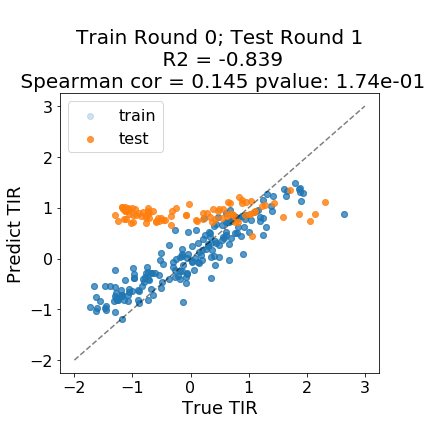

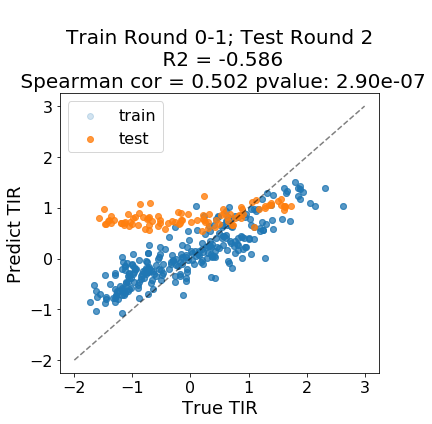

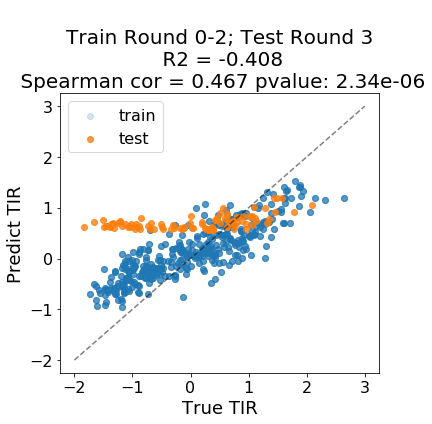

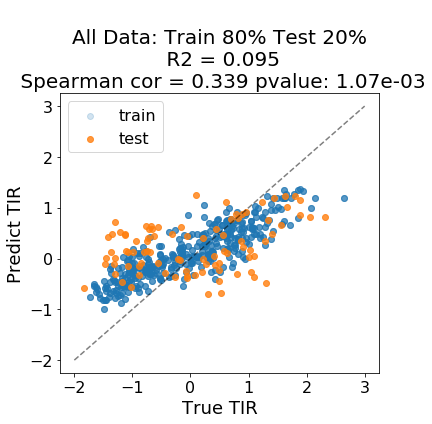

In [15]:
sns.set_palette('tab10') 
if plot_scatter_flag:
    scatter_plot_single(df_abc1_TT_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'All Data: Train 80% Test 20%'], 'abc1 TT', save_to = plot_path_supp)

In [16]:
if plot_scatter_flag:
    centering_flag = False
    unit_norm_flag = False

    df_abc1_FF_predictors = generate_predictors(df_abc1, kernel, embedding, kernel_norm_flag = True, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag)

X train shape:  (1055, 20)
X test shape:  (89, 20)
create kernel instance
No saved kernel matrix. Calculate and save kernel matrix...
centering_flag:  False
unit_norm_flag:  False
Kernel saved.
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (1589, 20)
X test shape:  (93, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (2147, 20)
X test shape:  (93, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l

#################################
  Evaluation   Train Round 0; Test Round 1
#################################
<function mean_squared_error at 0x7f4019d5d6a8>
Train:  0.28350109011840735
Test:  0.8403252988267403
<function r2_score at 0x7f4019d5d8c8>
Train:  0.6723153226798286
Test:  0.06693910443048467
spearman cor:
Train:  SpearmanrResult(correlation=0.8463617235506963, pvalue=2.3476913055622297e-290)
Test:  0.26886278515492   0.010844003382253626
Test pred fit:  [0.00180472 0.0168697 ]
Test ave fit:  [ 0.03619848 -1.59273318]
coverage rate: 
Train:  0.7668246445497631
Test:  0.5955056179775281
#################################
  Evaluation   Train Round 0-1; Test Round 2
#################################
<function mean_squared_error at 0x7f4019d5d6a8>
Train:  0.378004989211352
Test:  0.7034740004065209
<function r2_score at 0x7f4019d5d8c8>
Train:  0.5690171732617391
Test:  0.22587011585029304
spearman cor:
Train:  SpearmanrResult(correlation=0.7719917802404416, pvalue=1.264362013e-3

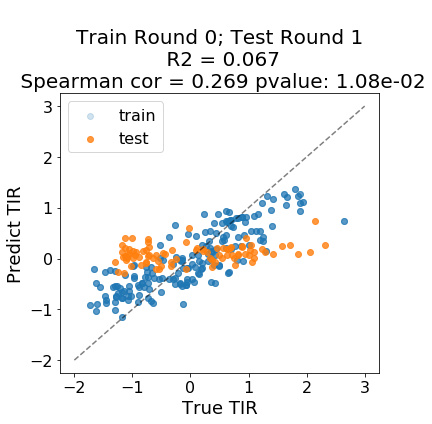

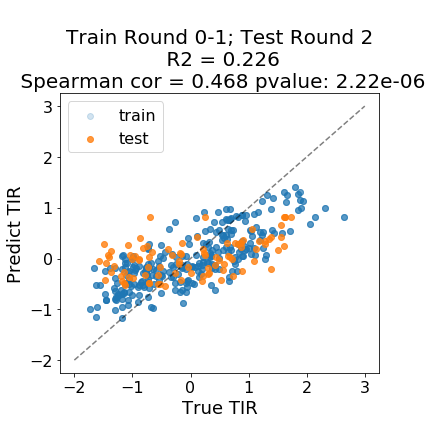

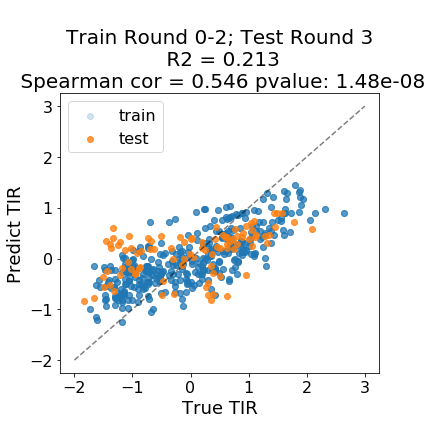

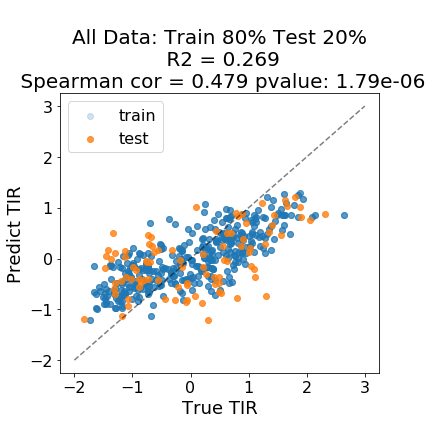

In [17]:
if plot_scatter_flag:
    
    scatter_plot_single(df_abc1_FF_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'All Data: Train 80% Test 20%'], 'abc1 FF', save_to=plot_path)

# Exploration v.s. Exploitation  

In [18]:
# projection 

# p1 = np.asarray([0,1])
# p2 = np.asarray([1,0])
# p3 = np.asarray([1,1])

def proj(to_proj_list, p1 = np.asarray([0,1]), p2 = np.asarray([1,0])):
    projections = []
    l2 = np.sum((p1-p2)**2)

    for p3 in to_proj_list:
#         t = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
        t = np.sum((p3 - p1) * (p2 - p1)) / l2
        projection = p1 + t * (p2 - p1)

        projections.append(projection)
    
    return np.asarray(projections)

def mean_vs_var_plot(predictor_list, title, plot_title = 'Prediction'):
    """Scatter plot for predictions.
    x-axis: label
    y-axis: prediction
    """
    # fig, axes = plt.subplots(1,4, figsize = (20,6))
    
    proj_df_list = []
    for i, predictor in enumerate(predictor_list[:3]):


        if i < 2:
            row = 0
        else:
            row = 1

        projections = proj(np.asarray(predictor.test_df[['pred mean', 'pred std']]))
        print(i)
        print('Round: ', predictor.test_df['Round'].unique())
        test_df = predictor.test_df.copy()
        test_df['proj0'] = projections[:,0]
        proj_df_list.append(test_df)

#             axes[row, i % 2].scatter(predictor.train_df['pred mean'], predictor.train_df['pred std'], label = 'train', alpha = 0.2)
        
        fig, axes = plt.subplots(1,1, figsize = (6,6))
        axes.scatter(predictor.test_df['pred mean'], predictor.test_df['pred std'], label = 'test', alpha = 0.8, color = tab10.colors[2])
        sns.set_palette('RdBu') 
        axes.scatter(projections[:,0], projections[:,1], label = 'projections', c = projections[:,0], cmap = 'RdBu')
        axes.set_ylabel('Predict STD')
        axes.set_xlabel('Predict TIR')
        axes.legend()
        axes.plot([0, 1], [1,0], '--', color = 'black', alpha = 0.5)
        axes.set_title('\n' + title[i]                  
#                  + '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
#                 '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
            )
        axes.set_xlim(-1,1.5)   
        axes.set_ylim(-1,1.5) 
#         fig.suptitle(plot_title, size = 16, y = 0.98)
        fig.tight_layout()
    #         fig.subplots_adjust(top=0.85)
        fig.savefig(plot_path_supp + 'proj_scatter_' + valid_path(plot_title) + '_' + str(i) + '.pdf')
    return proj_df_list

0
Round:  [1]
1
Round:  [2]
2
Round:  [3]


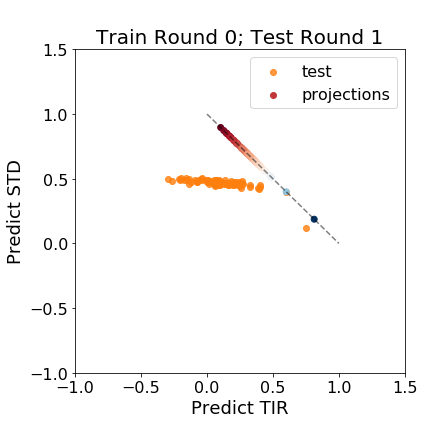

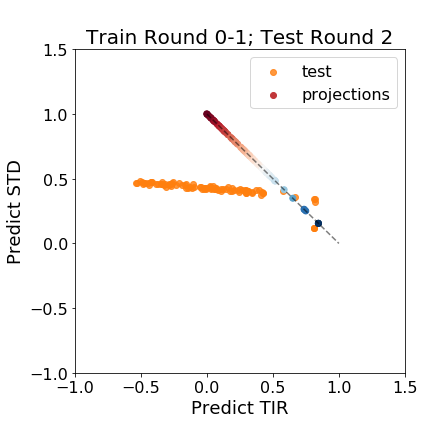

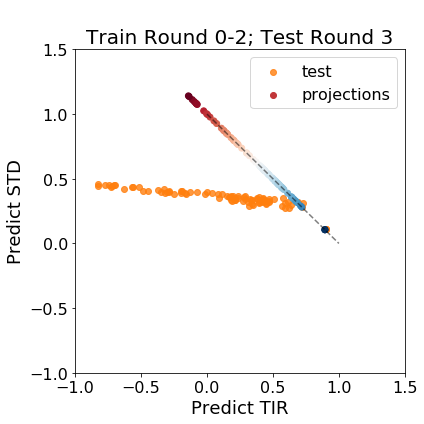

In [19]:
sns.set_palette('tab10') 
proj_df_list = mean_vs_var_plot(df_abc1_FF_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'All Data: Train 80% Test 20%'], 'abc1 FF')

In [20]:
proj_df = pd.concat(proj_df_list)[['RBS', 'proj0']]
# [['Name', 'RBS', 'proj0']]
df_e1_proj = df_e1[df_e1['Round'] > 0].merge(proj_df, on = 'RBS')

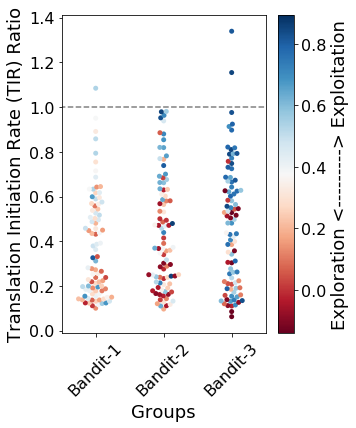

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colorbar
import matplotlib.colors
import matplotlib.cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

if plot_swarm_flag:
    fig, axes = plt.subplots(1, 1, figsize=(5, 6), sharex=False)
        
    sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_e1_proj, ax = axes, order=['Bandit-1', 'Bandit-2', 'Bandit-3'], hue = 'proj0', palette = 'RdBu')
#     sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_e1_proj, ax = axes, order=['Bandit-1', 'Bandit-2', 'Bandit-3'], hue = 'proj0', palette = colors)
    norm = plt.Normalize(df_e1_proj['proj0'].min(), df_e1_proj['proj0'].max())
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])

    axes.get_legend().remove()
    cb = axes.figure.colorbar(sm)
    cb.set_label('Exploration <---------> Exploitation')
    #     y = df_e1[df_e1['Group'] == 'Consensus']['AVERAGE']
#     axes.scatter(x = 0, y = y, color = color_dict['Consensus'])
    axes.plot([-1,9], [1,1], '--', color = 'grey')
#     axes.text(0, y + 0.05, 'SD')
    axes.set(xlabel='Groups', ylabel='Translation Initiation Rate (TIR) Ratio')
#     axes.set_title('Swarmplot with TIR Labels (ratio)')
    plt.legend([],[], frameon=False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(plot_path + 'swarmplot_proj.pdf')

# Heatmap

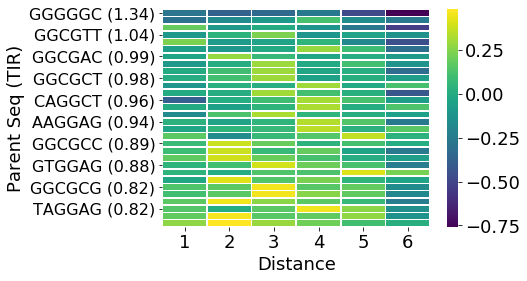

In [30]:
from scipy.spatial.distance import hamming

def separate(sequence):
    sequence2 = []
    for elem in sequence:
        sequence2.append(elem)
    return(sequence2)

instances1 = []
instances2 = []

for seq in df_TOP30['Core'].to_list():
    seq = str(seq)
    instances1.append(seq.upper())
    
for seq in df_ALL['Core'].to_list():
    seq = str(seq)
    instances2.append(seq.upper())

sequences_tir = []
sequences = []
distance = []
values = []
difference = []
TIR = []
for ins in instances1:  
    for h in range (6):
        sequences_tir.append(ins + ' (' + str(round(df_TOP30.loc[df_TOP30['Core'] == str(ins)]['TIR'].values.astype(float)[0],2)) + ')')
        sequences.append(ins)
        TIR.append((df_TOP30.loc[df_TOP30['Core'] == str(ins)]['TIR'].values.astype(float)[0]))
        distance.append(int(h+1))
        values.append(int(0))

data = pd.DataFrame ({'Distance': distance, 'Parent Seq (TIR)': sequences_tir,'Difference': values, 'Parent Seq': sequences, 'TIR':TIR}, columns = ['Distance','Parent Seq (TIR)','Difference','Parent Seq','TIR'])

for i,row in data.iterrows():
    seq1sep = separate(row['Parent Seq'])
    parent_value = df_TOP30.loc[df_TOP30['Core'] == str(row['Parent Seq'])]['TIR'].values.astype(float)[0]
    for seq2 in instances2:  
        seq2sep = separate(seq2)
        new_h = hamming(seq1sep,seq2sep)*len(seq1sep)
        new_value = df_ALL.loc[df_ALL['Core'] == str(seq2)]['TIR'].values.astype(float)[0]
        if new_value > row['Difference'] and row['Distance'] == new_h:
            row['Difference'] = float(new_value)
            data.loc[i, 'Difference'] = float(new_value - parent_value)

data = data.sort_values(by=['TIR'])
del data['Parent Seq']
del data['TIR']
data.reset_index(drop=True,inplace=True)
TIR2=[]

data = data.pivot('Parent Seq (TIR)','Distance','Difference')
for i,row in data.iterrows():
    TIR2.append(float(i[8:12]))
data['TIR'] = TIR2
data = data.sort_values(by=['TIR'],ascending=False)

del data['TIR']

In [ ]:
sns.heatmap(data, cmap='viridis',linewidths=.5,xticklabels=True,annot=False)
plt.yticks(fontsize=SMALL_SIZE,rotation=0)
plt.savefig(plot_path + 'heatmap.pdf', bbox_inches='tight')

# Sequence Logo

In [ ]:
from Bio import motifs
from Bio.Seq import Seq

instances=[]

for seq in df_TOP30['Core'].to_list():
    seq = str(seq)
    instances.append(Seq(seq.upper()))

m = motifs.create(instances)

background = {'A':0.23, 'C':0.2,'G':0.36, 'T': 0.21}
pssm = m.pwm.log_odds(background)
print(m.consensus)
print(m.pwm)
print(pssm)
print('Max score: ' + "%4.2f" % pssm.max)
print('Min score: ' + "%4.2f" % pssm.min)
print("mean = %0.2f, standard deviation = %0.2f" % (pssm.mean(background), pssm.std(background)))

kwds = {'color0' : 'black','color1' : "black",'color2' : "black",'logo_start' : '10'}

m.weblogo("logo.pdf",'PDF',kwds,dpi=300,stack_width = 'large',size='large')

GGGGGG
        0      1      2      3      4      5
A:   0.13   0.27   0.03   0.17   0.33   0.03
C:   0.13   0.10   0.30   0.00   0.17   0.10
G:   0.67   0.60   0.67   0.70   0.37   0.60
T:   0.07   0.03   0.00   0.13   0.13   0.27

        0      1      2      3      4      5
A:  -0.79   0.21  -2.79  -0.46   0.54  -2.79
C:  -0.58  -1.00   0.58   -inf  -0.26  -1.00
G:   0.89   0.74   0.89   0.96   0.03   0.74
T:  -1.66  -2.66   -inf  -0.66  -0.66   0.34

Max score: 4.75
Min score: -inf
mean = 2.19, standard deviation = 1.73


# Positional change line plot

ipykernel_launcher:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Sup

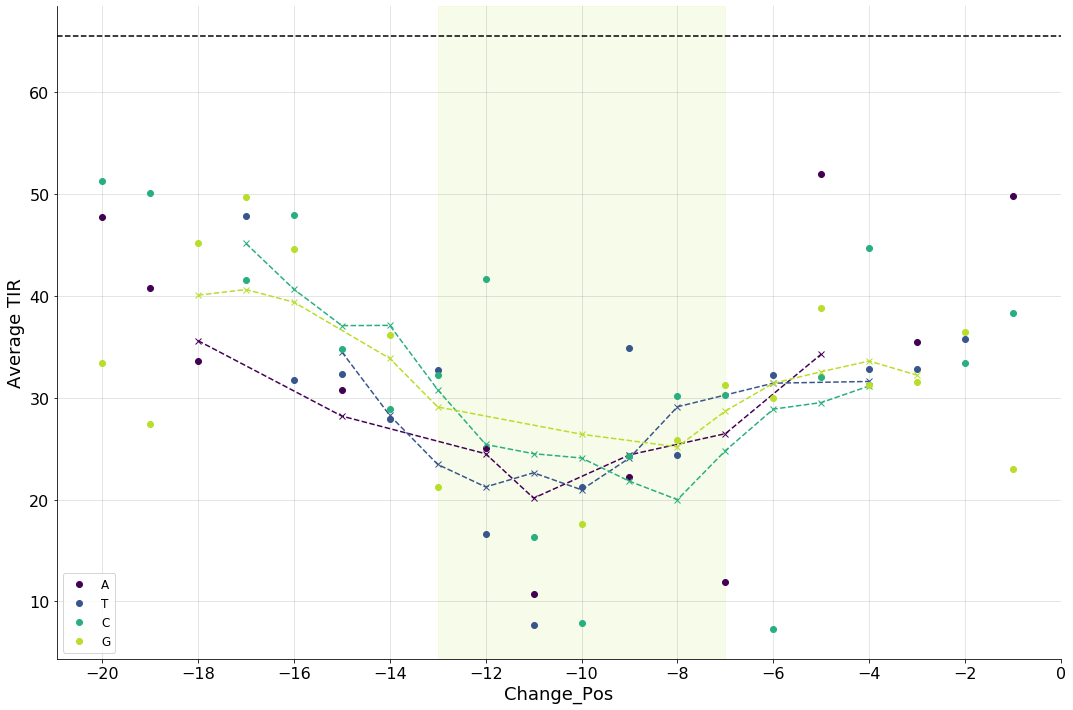

In [27]:
df_Pos=df_Pos[df_Pos.AVERAGE != 65.553]

for base in 'ATCG':
    df_Pos['Rolling' + base] = df_Pos["AVERAGE"].loc[df_Pos['Base'] == base].rolling(window=5,center=True).mean()
fig, ax = plt.subplots( figsize=(18,12))
for base,colour in zip('ATCG',('#440154FF','#39568CFF','#29AF7FFF','#B8DE29FF')):
    ax1 = plt.plot(df_Pos['Change_Pos'].loc[df_Pos['Base'] == base],df_Pos['AVERAGE'].loc[df_Pos['Base'] == base],ls=None,marker='o',linewidth=0,c=colour,label=base)
    ax2 = plt.plot(df_Pos['Change_Pos'].loc[df_Pos['Base'] == base],df_Pos['Rolling' + base].loc[df_Pos['Base'] == base],ls='--',marker='x',c=colour)
plt.axvspan(-7, -13, color='#B8DE29FF', alpha=0.1)
plt.axhline(65.553,color="black",ls="--")
ax.set_xlabel("Change_Pos");
ax.set_facecolor("white");
plt.grid(color='k', linestyle='-', linewidth=1,alpha=0.1);
plt.xticks(np.arange(-20, 1, step=2))
ax.set_ylabel("Average TIR");
ax.legend(fontsize="large");
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig.savefig(plot_path_supp + 'core_vs_noncore.pdf', bbox_inches='tight', dpi=300)

# SD histogram

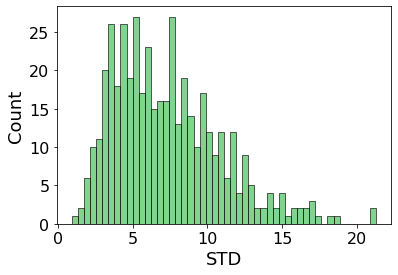

In [24]:
sns.histplot(data=df_SD, x="STD",bins=50,kde=False,color='#55C667FF')
plt.savefig(plot_path_supp + 'SDhist.pdf')

# SD jointplot

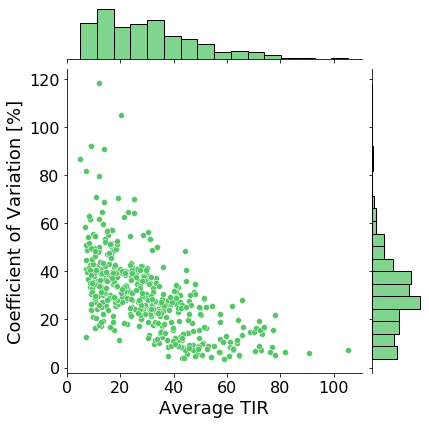

In [25]:
sns.jointplot(data=df_SD,x="Average TIR",y="Coefficient of Variation [%]",color='#55C667FF')
plt.savefig(plot_path_supp + 'SD.pdf')

# SD scatterplot

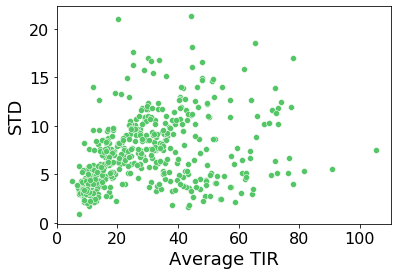

In [26]:
sns.scatterplot(data=df_SD, x="Average TIR",y="STD",color='#55C667FF')
plt.savefig(plot_path_supp + 'SDvsTIR.pdf')